数据集：
[Store Sales - Time Series Forecasting](https://cloud.tencent.com/developer/article/2384397)

reference:
> [使用Transformer 模型进行时间序列预测](https://cloud.tencent.com/developer/article/2384397)

> [Kaggle实战：Store Sales - Time Series Forecasting](https://blog.csdn.net/weixin_43907802/article/details/122798776)

> [时序预测Time Series Forecasting:实体店销售](https://www.cnblogs.com/March7th/p/17289259.html)

比赛使用的评估指标是均方根误差（RMSLE）。（取对数意味着预测大的销售数字和小的销售数字的误差将更均匀地影响结果）

目标：预测未来16天每个产品、每个商店的销售情况。

原始数据说明：  

train.csv  
+ The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
+ store_nbr identifies the store at which the products are sold.
+ family identifies the type of product sold.
+ sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
+ onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

test.csv
+ The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
+ The dates in the test data are for the 15 days after the last date in the training data.

sample_submission.csv
+ A sample submission file in the correct format.

stores.csv
+ Store metadata, including city, state, type, and cluster.
+ cluster is a grouping of similar stores.

oil.csv
+ Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

holidays_events.csv
+ Holidays and Events, with metadata
+ NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is 
+ Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
+ Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

# 方案一：

直接对train的非数值特征进行LabelEncoder编码转化为数值类型特征，对数据集切分，进行随机森林回归预测
 
该方案在验证得分为0.8230855313648102，而在提交后的测试集得分为0.62676

In [1]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report

train = pd.read_csv("data/train.csv")
oil = pd.read_csv("data/oil.csv")
transaction = pd.read_csv("data/transactions.csv")
stores = pd.read_csv("data/stores.csv")
test = pd.read_csv("data/test.csv")
holidays_events= pd.read_csv("data/holidays_events.csv")

train.drop("id",inplace=True,axis=1)
train["family"]=LabelEncoder().fit_transform(train["family"])
Y=train["sales"]
train= pd.concat([train["store_nbr"],train["family"],train["onpromotion"]],axis=1)
x_train,x_test,y_train,y_test = train_test_split(train,Y,test_size=0.3,random_state=0)

model = RandomForestRegressor(random_state=1, max_depth=100)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))

test["family"]=LabelEncoder().fit_transform(test["family"])
test_= pd.concat([test["store_nbr"],test["family"],test["onpromotion"]],axis=1)
pd.DataFrame(pd.concat([test["id"],pd.DataFrame(model.predict(test_),columns=["sales"])],axis=1)).to_csv("submission.csv",index=False)

0.8230855313648102


# 方案二：

先对整体数据进行进行探索：

这是一家位于厄瓜多尔的大型杂货零售商。需要一个能够预测不同商店所销售的数千种商品的单位销售额的模型。不同的数据集描述了厄瓜多尔2013年至2017年期间的销售、商店、假期数据等。

所有的数据集：
 1. 假日_事件：一个包含所有厄瓜多尔假日和事件的列表；

 2. 石油：一个石油价格的列表，旨在作为厄瓜多尔的经济指标；

 3. 商店：一个包含我们商店信息的数据集：包括城市、州、类型和其他；

 4. 交易：一个数据集，包含每个商店每天的交易总数；

 5. 测试：我们需要预测的16天销售额的一般测试集；

 6. 训练：一个巨大的训练集，包含大约4年的数据，用于预测我们的测试销售数据。

In [26]:
import numpy as np
import pandas as pd
import random
import datetime as dt
import seaborn as sns
from re import search
import matplotlib.pyplot as plt
 
random.seed(333)
pd.options.mode.chained_assignment = None
 
import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/AUTOMOTIVE.csv
data/BABY CARE.csv
data/BEAUTY.csv
data/BEVERAGES.csv
data/BOOKS.csv
data/BREADBAKERY.csv
data/CELEBRATION.csv
data/CLEANING.csv
data/DAIRY.csv
data/DELI.csv
data/EGGS.csv
data/FROZEN FOODS.csv
data/GROCERY I.csv
data/GROCERY II.csv
data/HARDWARE.csv
data/holidays_events.csv
data/HOME AND KITCHEN I.csv
data/HOME AND KITCHEN II.csv
data/HOME APPLIANCES.csv
data/HOME CARE.csv
data/LADIESWEAR.csv
data/LAWN AND GARDEN.csv
data/LINGERIE.csv
data/LIQUOR,WINE,BEER.csv
data/MAGAZINES.csv
data/MEATS.csv
data/oil.csv
data/PERSONAL CARE.csv
data/PET SUPPLIES.csv
data/PLAYERS AND ELECTRONICS.csv
data/POULTRY.csv
data/PREPARED FOODS.csv
data/PRODUCE.csv
data/sample_submission.csv
data/SCHOOL AND OFFICE SUPPLIES.csv
data/SEAFOOD.csv
data/stores.csv
data/test.csv
data/train.csv
data/transactions.csv


In [27]:
original_train = pd.read_csv('data/train.csv')
original_test = pd.read_csv('data/test.csv')
 
print(original_train.info())
original_train.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


id             False
date           False
store_nbr      False
family         False
sales          False
onpromotion    False
dtype: bool

In [28]:
print(original_train['store_nbr'].unique().__len__())
print(original_train['family'].unique().__len__())

54
33


In [29]:
print("train day length: ",len(original_train) / 54 / 33) 
print("star at:",original_train['date'].iloc[0])
print("end at: ",original_train['date'].iloc[-1],"\n") 
 
print("test day scale: ",len(original_test) / 54 / 33)
print("star at:",original_test['date'].iloc[0])
print("end at: ",original_test['date'].iloc[-1])

train day length:  1684.0
star at: 2013-01-01
end at:  2017-08-15 

test day scale:  16.0
star at: 2017-08-16
end at:  2017-08-31


测试集和训练集均没有缺失值，store_nbr有54种类型的数据，family有33种类型的数据；

训练集的时间范围为2013-01-01~2017-08-15，时间跨度为1684天

测试集的时间范围为2017-08-16~2017-08-31，时间跨度为16天

d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

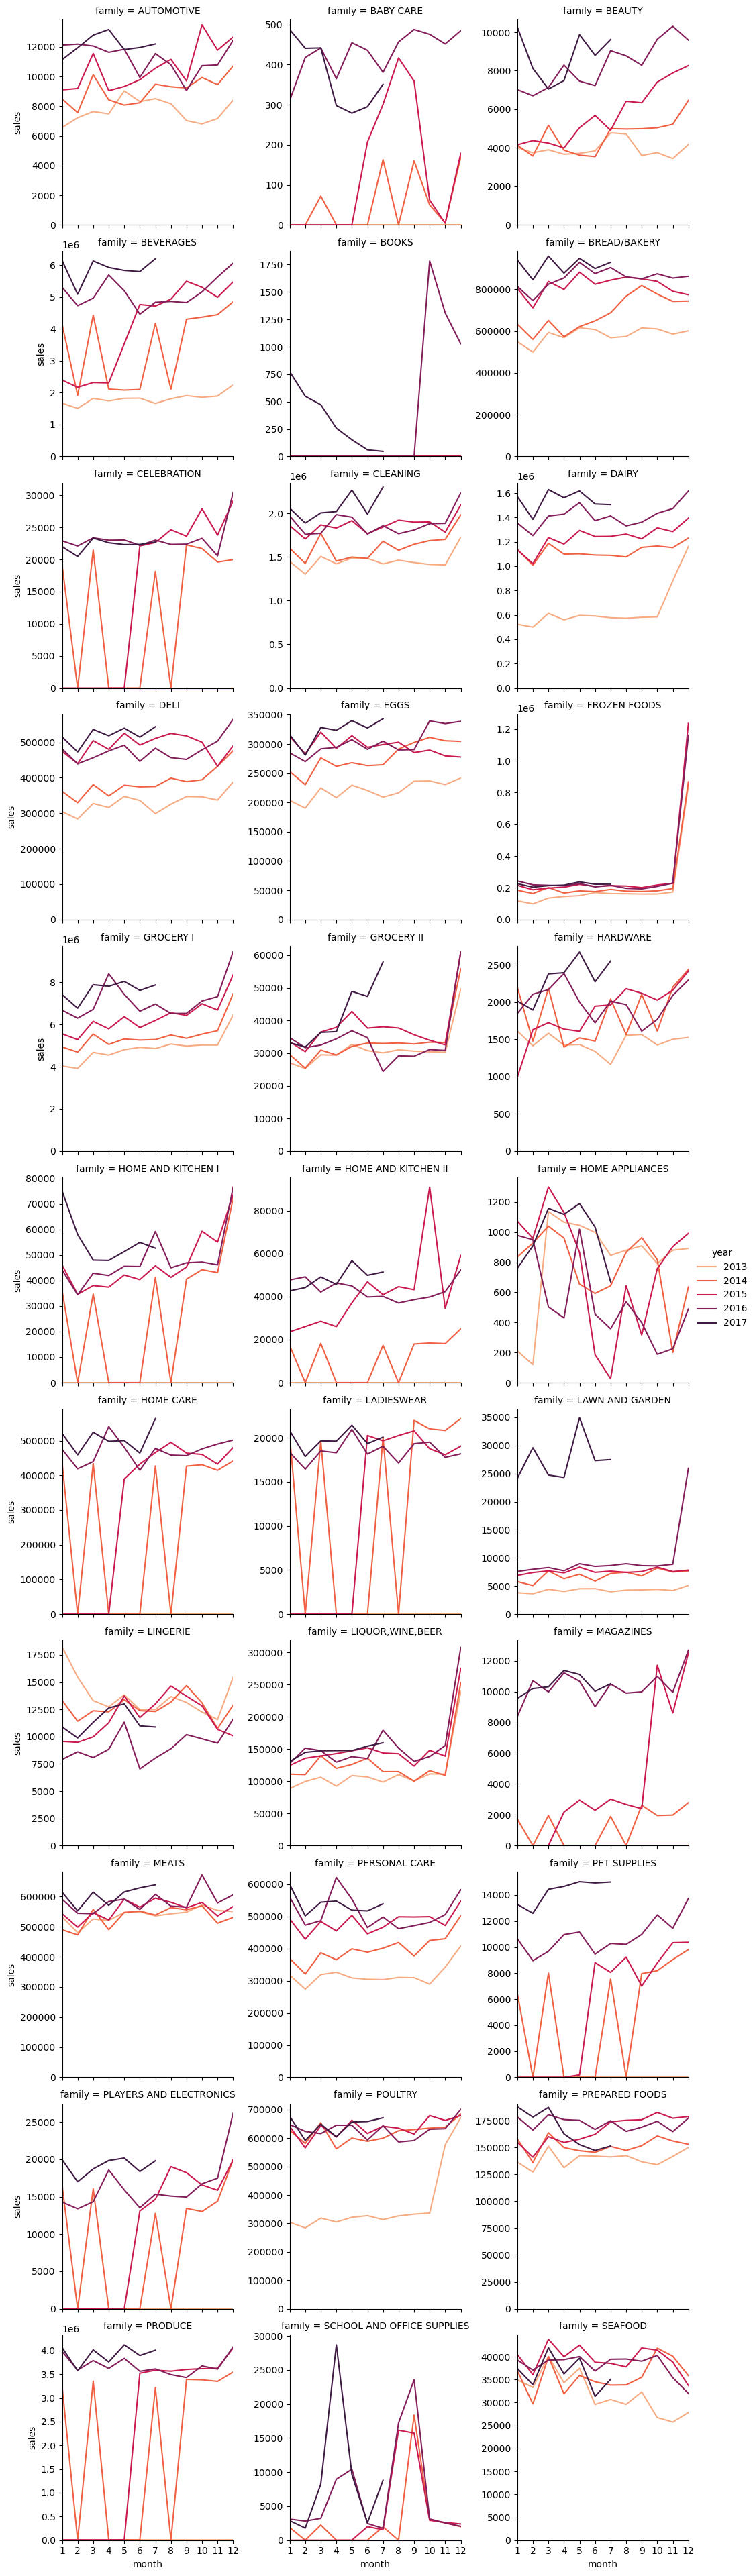

In [30]:
original_train['date'] = pd.to_datetime(original_train['date'])
original_train['year'] = original_train['date'].dt.year
original_train['month'] = original_train['date'].dt.month
 
monthly_sales = original_train.groupby(['family', 'year','month']).agg({"sales" : "sum"}).reset_index()
 
# The value of the last month (for each 33 products) we change to nan, as otherwise it will distort
# the graph since this month's data is incomplete:
for x in range(33):
    z = 55+(x*56)
    monthly_sales.at[z,'sales'] = np.nan 
 
# We use seaborn's FacetGrid with a col_wrap of 3 to show all the graphs in rows of three.
# We also need sharey = False so that the y axis of all the graphs is not shared but individual.
product_lineplots = sns.FacetGrid(monthly_sales, col="family", hue='year', sharey=False, height=3.5, col_wrap=3, palette='rocket_r')
product_lineplots.map(sns.lineplot, "month", 'sales')
product_lineplots.add_legend()
product_lineplots.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

一些月份对我们的一些产品显示出奇怪的行为（例如宠物用品、农产品......）：

2014年: 二月(2), 四月(4), 五月(5), 六月(6), 八月(8)

2015年: 一月(1), 二月(2), 三月(3), 四月(4), 五月(5)

12月：

似乎是许多产品销售最好的月份，可能是因为它是一个有圣诞节和新年前夕的假期。

书籍：

似乎 "书籍 "类别正处于被淘汰的末期，把这个预测值设为零。

学校和办公用品：

似乎在4月达到高峰，但在今年之前更多是在8-9月。这些日期对任务来说很重要，因为我们的预测也发生在这个高峰的中间（8月底）。

d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


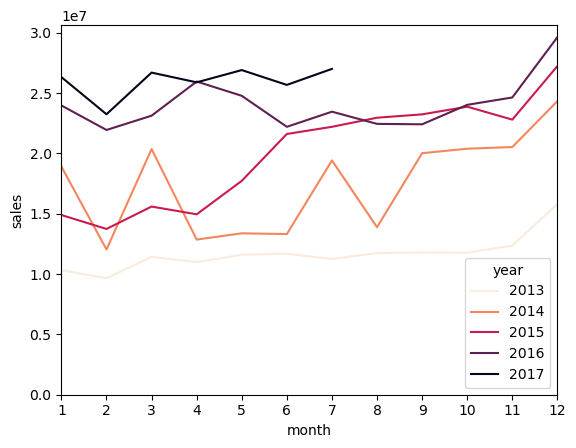

In [31]:

total_monthly_sales = original_train.groupby(['year','month']).agg({"sales" : "sum"}).reset_index()
 
total_monthly_sales.at[55,'sales'] = np.nan
 
total_plot = sns.lineplot(x='month', y='sales', hue='year', palette='rocket_r', data=total_monthly_sales)
total_plot.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

plt.show()

用于训练的数据框：

1. 一个独立的*数据框架：一天=一行，独立于商店编号和产品组，在这里创建取决于日期的变量，与商店无关（例如，一周中的一天）。

2. 一个所有商店的数据框架：创建一个数据框架，在这里汇总所有54家商店，并添加取决于商店的变量（例如：商店_关闭）。

3. 一个产品组数据框：在主数据框中汇总每个产品，然后添加之前从独立df和所有商店df创建的数据。



对于独立的数据框架创建了以下函数：

+ create_date_df：用于将数据框架聚合成一个按日期分组的小框架。

+ create_paydays：对于政府工作（厄瓜多尔最大的雇主），工资是在每月的第一天和15日支付。这个函数创建了发薪日列：两个有效的发薪日，作为一个刻度，向上计数，有一个var显示人们多久前发过工资。

+ onehotencode：将选择的列变成不同的二进制列的函数（也将对所有商店df使用这个函数）。

+ independant pipeline：合并所有之前的函数以创建一个数据框架的管道。在这里添加了额外的变量：常规的日期变量，一个表示地震发生时间的变量，以及一个表示学校开始时间的变量（以增加学校和办公用品得分）。

对于所有商店数据框架创建了以下函数：

+ create_multi_store_one_product_df: 一个小函数，用于创建一个聚集在商店和过滤一个产品的数据框架。

+ create_holiday_variables: 创建所有不同节日变量的函数（取决于商店的位置）。

+ create_location_variables: 函数，根据商店位置创建一些额外的变量。添加的外部数据，是在kaggle上的初始数据框架中没有的。海拔高度（厄瓜多尔是一个多山的国家）和城市密度（在大城市的商店和在人口稀少的城镇的商店在某些时候可能有非常不同的效果）。

+ all_stores_pipeline：管道函数，合并前面的函数（也执行onehotencode）以创建所有商店df。

产品数据框

+ 变量创建阶段创建33个产品数据框架,整合了独立和所有商店的数据框架。

In [32]:
def create_date_df(df, store_nr):
 
    single_store_df = df[df['store_nbr'] == store_nr]
    single_store_series = single_store_df.groupby(["date"]).sum(numeric_only=True)
 
    return single_store_series
def create_payday_anchors(df):
 
    df.reset_index(inplace=True)
    df['Payday'] = 0
 
    for id, row in df.iterrows():
 
        if search('-01$', row['date']):
            df.at[id - 1, 'Payday'] = 1
 
        if search('-15$', row['date']):
            df.at[id, 'Payday'] = 1
 
    df = df[:-1]
 
    return df
def onehotencode(df, list_of_variables):
 
    column_name_list = list()
    my_category_list = list()
 
    for column in list_of_variables:
 
        categories = df[column].unique().tolist()
 
        for i in categories:
 
            this_list = ((df[column] == i) * 1).tolist()
 
            column_name_list.append(column + str(i))
            my_category_list.append(this_list)
 
            print('Finished ' + str(i))
 
        print(str(column) + ' is done.')
 
    onehotencode_df = pd.DataFrame(my_category_list).transpose()
    onehotencode_df.columns = np.asarray(column_name_list)
 
    return onehotencode_df
def independant_pipeline():
 
    original_train = pd.read_csv('data/train.csv')
    original_test = pd.read_csv('data/test.csv')
 
    # Get one store one product DF:
    one_store_df = create_date_df(original_train, 1)
    one_store_df_test = create_date_df(original_test, 1)
    one_store_df.drop('sales', axis=1, inplace=True)
 
    one_store_df = pd.concat([one_store_df, one_store_df_test])
 
    del original_train
    del original_test
 
    ########################
    # Add Paydays          #
    ########################
 
    one_store_df = create_payday_anchors(one_store_df)
 
    payday_series = one_store_df['Payday']
    payday_count = 0
    payday_scale_list = list()
 
    for x in range(payday_series.__len__()):
 
        if payday_series[x] == 1:
            payday_count = 0
            payday_scale_list.append(payday_count)
        else:
            payday_count += 1
            payday_scale_list.append(payday_count)
 
    one_store_df['Payday_Scale'] = payday_scale_list
 
    one_store_df.drop(['id'], axis=1, inplace=True)
 
    ######################
    # Add Date Variables #
    ######################
 
    dayoftheweek_list = list()
    dayoftheyear_list = list()
    monthoftheyear_list = list()
    year_list = list()
 
    for x in range(1700): # because 1700 different days
 
        thisdate = one_store_df['date'][x]
        thisdayoftheweek = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%A')
        thisdayoftheyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%j')
        thismonthoftheyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%B')
        thisyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%Y')
 
        dayoftheweek_list.append(thisdayoftheweek)
        dayoftheyear_list.append(thisdayoftheyear)
        monthoftheyear_list.append(thismonthoftheyear)
        year_list.append(thisyear)
 
    one_store_df['DayOfTheWeek'] = dayoftheweek_list
    one_store_df['DayOfTheYear'] = dayoftheyear_list
    one_store_df['MonthOfTheYear'] = monthoftheyear_list
    one_store_df['Year'] = year_list
 
    one_store_df['DayOfTheYear'] = pd.to_numeric(one_store_df['DayOfTheYear'])
 
    # Convert DayOfTheWeek to numeric:
 
    dayoftheweek_scale_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
                               'Friday': 5, 'Saturday': 6, 'Sunday': 7}
 
    one_store_df['dayoftheweek_scale'] = one_store_df['DayOfTheWeek'].map(dayoftheweek_scale_dict)
 
    ########################
    # OneHotEncode         #
    ########################
 
    onehotcolumnlist = ('DayOfTheWeek', 'MonthOfTheYear', 'Year')
    onehotencode_df = onehotencode(one_store_df, onehotcolumnlist)
    one_store_df = pd.concat([one_store_df, onehotencode_df], axis=1)
 
    ########################
    # Drop Some Cols       #
    ########################
 
    one_store_df.drop(['store_nbr', 'DayOfTheWeek', 'onpromotion'], axis=1, inplace=True)
 
    return one_store_df
# --- Execute Pipeline --- #
 
independant_df = independant_pipeline()

Finished Tuesday
Finished Wednesday
Finished Thursday
Finished Friday
Finished Saturday
Finished Sunday
Finished Monday
DayOfTheWeek is done.
Finished January
Finished February
Finished March
Finished April
Finished May
Finished June
Finished July
Finished August
Finished September
Finished October
Finished November
Finished December
MonthOfTheYear is done.
Finished 2013
Finished 2014
Finished 2015
Finished 2016
Finished 2017
Year is done.


In [33]:
def create_multi_store_one_product_df(df, product_name):
 
    multistore_single_product = df[df['family'] == product_name]
 
    return multistore_single_product
def create_holiday_variables(df):
 
    holidays = pd.read_csv('data/holidays_events.csv')
 
    holidays = holidays[holidays['transferred'] == False]
    holidays['holiday_type'] = holidays['type']
    holidays.drop(['transferred', 'description', 'type'], axis=1, inplace=True)
 
    national_holidays = holidays[holidays['locale'] == 'National']
    national_holidays['national_holiday_type'] = national_holidays['holiday_type']
    national_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)
    df = pd.merge(df, national_holidays, how='left', on=['date'])
 
    state_holidays = holidays[holidays['locale'] == 'Regional']
    state_holidays['state'] = state_holidays['locale_name']
    state_holidays['state_holiday_type'] = state_holidays['holiday_type']
    state_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    df = pd.merge(df, state_holidays, how='left', on=['date', 'state'])
 
    city_holidays = holidays[holidays['locale'] == 'Local']
    city_holidays['city'] = city_holidays['locale_name']
    city_holidays['city_holiday_type'] = city_holidays['holiday_type']
    city_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    city_holidays.drop([265], axis=0, inplace=True)
    df = pd.merge(df, city_holidays, how='left', on=['date', 'city'])
 
    df['holiday_type'] = np.nan
    df['holiday_type'] = df['holiday_type'].fillna(df['national_holiday_type'])
    df['holiday_type'] = df['holiday_type'].fillna(df['state_holiday_type'])
    df['holiday_type'] = df['holiday_type'].fillna(df['city_holiday_type'])
    df.drop(['national_holiday_type', 'state_holiday_type', 'city_holiday_type'], axis=1, inplace=True)
 
    return df
def create_location_variables(df):
 
    stores = pd.read_csv('data/stores.csv')
 
    # stores['city'].unique()
    # ['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
    #  'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
    #  'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
    #  'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen']
 
    # Height dict:
    Height = {'Quito': 2850, 'Santo Domingo': 550, 'Cayambe': 2830, 'Latacunga': 2860,
              'Riobamba': 2754, 'Ibarra': 2225, 'Guaranda': 2668, 'Puyo': 950,
              'Ambato': 2577, 'Guayaquil': 0, 'Salinas': 0, 'Daule': 0,
              'Babahoyo': 0, 'Quevedo': 75, 'Playas': 0, 'Libertad': 36,
              'Cuenca': 2560, 'Loja': 2060, 'Machala': 0, 'Esmeraldas': 15,
              'Manta': 0, 'El Carmen': 250}
 
    # Elevation:
    # 0 = 0 - 200 (10)
    # 1 = 200-700 (2)
    # 2 = 700-1500 (1)
    # 3 = 1500-2300 (2)
    # 4 = 2300-3000 (7)
 
    Population = {'Quito': 2000000, 'Santo Domingo': 460000, 'Cayambe': 40000, 'Latacunga': 100000,
                  'Riobamba': 157000, 'Ibarra': 150000, 'Guaranda': 35000, 'Puyo': 40000,
                  'Ambato': 350000, 'Guayaquil': 2750000, 'Salinas': 50000, 'Daule': 130000,
                  'Babahoyo': 105000, 'Quevedo': 200000, 'Playas': 40000, 'Libertad': 105000,
                  'Cuenca': 445000, 'Loja': 200000, 'Machala': 260000, 'Esmeraldas': 200000,
                  'Manta': 240000, 'El Carmen': 120000}
 
    # Population:
    # 0 = 0-60000 (5)
    # 1 = 60000-160000 (12)
    # 2 = 160000-280000 (3)
    # 3 = 280000+ (2)
 
    Size = {'Quito': 372, 'Santo Domingo': 60, 'Cayambe': 378, 'Latacunga': 370,
            'Riobamba': 59, 'Ibarra': 242, 'Guaranda': 520, 'Puyo': 88,
            'Ambato': 47, 'Guayaquil': 345, 'Salinas': 27, 'Daule': 475,
            'Babahoyo': 175, 'Quevedo': 300, 'Playas': 280, 'Libertad': 28,
            'Cuenca': 71, 'Loja': 44, 'Machala': 67, 'Esmeraldas': 70,
            'Manta': 60, 'El Carmen': 1250}
 
    stores["City_Population"] = stores['city'].map(Population)
    stores["City_Elevation"] = stores['city'].map(Height)
    stores["City_Size"] = stores['city'].map(Size)
    stores["City_Density"] = round(stores["City_Population"] / stores["City_Size"],0)
    stores["City_Population_Category"] = 0
    stores["City_Elevation_Category"] = 0
    stores["City_Size_Category"] = 0
    stores["City_Density_Category"] = 0
 
    for id, row in stores.iterrows():
 
        if row['City_Elevation'] < 200:
            stores.at[id, 'City_Elevation_Category'] = 0
        elif row['City_Elevation'] < 700:
            stores.at[id, 'City_Elevation_Category'] = 1
        elif row['City_Elevation'] < 1500:
            stores.at[id, 'City_Elevation_Category'] = 2
        elif row['City_Elevation'] < 2300:
            stores.at[id, 'City_Elevation_Category'] = 3
        else:
            stores.at[id, 'City_Elevation_Category'] = 4
 
        if row['City_Population'] < 60000:
            stores.at[id, 'City_Population_Category'] = 0
        elif row['City_Population'] < 160000:
            stores.at[id, 'City_Population_Category'] = 1
        elif row['City_Population'] < 280000:
            stores.at[id, 'City_Population_Category'] = 2
        else:
            stores.at[id, 'City_Population_Category'] = 3
 
        if row['City_Size'] < 150:
            stores.at[id, 'City_Size_Category'] = 0
        elif row['City_Size'] < 325:
            stores.at[id, 'City_Size_Category'] = 1
        elif row['City_Size'] < 1000:
            stores.at[id, 'City_Size_Category'] = 2
        else:
            stores.at[id, 'City_Size_Category'] = 3
 
        if row['City_Density'] < 150:
            stores.at[id, 'City_Density_Category'] = 0
        elif row['City_Density'] < 325:
            stores.at[id, 'City_Density_Category'] = 1
        elif row['City_Density'] < 1000:
            stores.at[id, 'City_Density_Category'] = 2
        elif row['City_Density'] < 3000:
            stores.at[id, 'City_Density_Category'] = 3
        elif row['City_Density'] < 7000:
            stores.at[id, 'City_Density_Category'] = 4
        else:
            stores.at[id, 'City_Density_Category'] = 5
 
    city_variables_df = stores[['store_nbr', 'City_Elevation_Category', 'City_Population_Category', 'City_Size_Category',
                                'City_Density_Category', 'City_Density']]
    df = pd.merge(df, city_variables_df, how='left', on='store_nbr')
    df.drop(['city','state'], axis=1, inplace=True)
 
    return df
def all_stores_pipeline():
 
    originaltrainFull = pd.read_csv('data/train.csv')
    originaltest = pd.read_csv('data/test.csv')
 
    stores = pd.read_csv('data/stores.csv')
    transactions = pd.read_csv('data/transactions.csv')
 
    all_stores_df = create_multi_store_one_product_df(originaltrainFull, 'AUTOMOTIVE')
    all_stores_df_test = create_multi_store_one_product_df(originaltest, 'AUTOMOTIVE')
    all_stores_df.drop('sales', axis=1, inplace=True)
 
    all_stores_df = pd.concat([all_stores_df, all_stores_df_test])
    all_stores_df.drop(['id', 'family', 'onpromotion'], axis=1, inplace=True)
 
    all_stores_df = pd.merge(all_stores_df, stores, how='left', on=['store_nbr'])
 
    del originaltest
    del originaltrainFull
 
    #########################
    # Add Holiday Variables #
    #########################
 
    all_stores_df = create_holiday_variables(all_stores_df)
 
    ##########################
    # Add Location Variables #
    ##########################
 
    all_stores_df = create_location_variables(all_stores_df)
 
    ################################
    # Create Store Closed Variable #
    ################################
 
    all_stores_df = pd.merge(all_stores_df, transactions, how='left', on=['date', 'store_nbr'])
    all_stores_df['transactions'].fillna(0, inplace=True)
 
    store_closed = [1 if x == 0 else 0 for x in all_stores_df['transactions']]
 
    all_stores_df['store_closed'] = store_closed
    all_stores_df['store_closed'].iloc[-864:] = 0
 
    all_stores_df.drop('transactions', axis=1, inplace=True)
 
    ###################
    # OneHotEncode    #
    ###################
 
    all_stores_df['isholiday'] = 1
    thislist = all_stores_df['holiday_type'].isna()
    all_stores_df.loc[thislist,'isholiday'] = 0
 
    onehotcolumnlist = ('store_nbr', 'type', 'cluster', 'holiday_type', 'City_Elevation_Category',
                        'City_Population_Category', 'City_Density_Category', 'City_Size_Category')
 
    onehotencode_df = onehotencode(all_stores_df, onehotcolumnlist)
    all_stores_df = pd.concat([all_stores_df, onehotencode_df], axis=1)
 
    ###################
    # Drop Some Cols  #
    ###################
 
    all_stores_df.drop(['type', 'cluster', 'holiday_type'], axis=1, inplace=True)
 
    return all_stores_df
# --- Execute Pipeline --- #
 
all_stores_df = all_stores_pipeline()

Finished 1
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 2
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished 29
Finished 3
Finished 30
Finished 31
Finished 32
Finished 33
Finished 34
Finished 35
Finished 36
Finished 37
Finished 38
Finished 39
Finished 4
Finished 40
Finished 41
Finished 42
Finished 43
Finished 44
Finished 45
Finished 46
Finished 47
Finished 48
Finished 49
Finished 5
Finished 50
Finished 51
Finished 52
Finished 53
Finished 54
Finished 6
Finished 7
Finished 8
Finished 9
store_nbr is done.
Finished D
Finished C
Finished B
Finished E
Finished A
type is done.
Finished 13
Finished 15
Finished 6
Finished 7
Finished 3
Finished 12
Finished 16
Finished 9
Finished 1
Finished 10
Finished 8
Finished 2
Finished 4
Finished 5
Finished 11
Finished 14
Finished 17
cluster is done.
Finished Holiday
Finished nan
Finished Work Day
Finished Addi

In [34]:
def full_product_pipeline(family, independant_df=independant_df, all_stores_df=all_stores_df):
 
    originaltrainFull = pd.read_csv('data/train.csv')
    originaltest = pd.read_csv('data/test.csv')
 
    multistore_product = create_multi_store_one_product_df(originaltrainFull, family)
 
    # merge with test:
    multistore_product_test = create_multi_store_one_product_df(originaltest, family)
    multistore_product_test['sales'] = np.nan
 
    del originaltrainFull
    del originaltest
 
    # take log of sales:
    multistore_product['sales'] = np.log1p(multistore_product['sales']+1)
 
    msp_full = pd.concat([multistore_product, multistore_product_test])
 
    # reset index:
    msp_full.reset_index(inplace=True, drop=True)
 
    ######################
    # Add Independant DF #
    ######################
 
    msp_full = pd.merge(msp_full, independant_df, how='left', on=['date'])
 
    #####################
    # Add All Stores DF #
    #####################
 
    msp_full = pd.merge(msp_full, all_stores_df, how='left', on=['date', 'store_nbr'])
 
    ############################
    # Add Earthquake Info      #
    ############################
 
    earthquake_day = [1 if x == '2016-04-16' else 0 for x in msp_full['date']]
    earthquake_impact = [1 if (x > '2016-04-16') & (x < '2016-05-16') else 0 for x in msp_full['date']]
 
    msp_full['earthquake_day'] = earthquake_day
    msp_full['earthquake_impact'] = earthquake_impact
 
    ############################
    # Add School Info          #
    ############################
 
    school_preparation = [1 if (x > '2014-09-15') & (x < '2014-10-15') or (x > '2015-09-15') & (x < '2015-10-15')
                          or (x > '2016-09-15') & (x < '2016-10-15') or (x > '2017-09-15') & (x < '2017-10-15')
                          else 0 for x in msp_full['date']]
 
    msp_full['school_preparation'] = school_preparation
 
    #############################
    # Clean DF before modelling #
    #############################
 
    msp_full.drop(['family', 'MonthOfTheYear'], axis=1, inplace=True)
 
    return msp_full
# --- Execute Full Product Pipeline for each product --- #
 
# List all product families:
 
list_of_families = ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                    'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
                    'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
                    'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
                    'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
                    'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
                    'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
                    'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
                    'SEAFOOD']
 
# Create new .csv for each product family:
 
for x in list_of_families:
 
    this_df = full_product_pipeline(x)
 
    if x == 'BREAD/BAKERY':
 
            x = 'BREADBAKERY'
 
    print('Completed eda for ' + str(x))
    this_df.to_csv('data/'+str(x)+'.csv', index=False)

Completed eda for AUTOMOTIVE
Completed eda for BABY CARE
Completed eda for BEAUTY
Completed eda for BEVERAGES
Completed eda for BOOKS
Completed eda for BREADBAKERY
Completed eda for CELEBRATION
Completed eda for CLEANING
Completed eda for DAIRY
Completed eda for DELI
Completed eda for EGGS
Completed eda for FROZEN FOODS
Completed eda for GROCERY I
Completed eda for GROCERY II
Completed eda for HARDWARE
Completed eda for HOME AND KITCHEN I
Completed eda for HOME AND KITCHEN II
Completed eda for HOME APPLIANCES
Completed eda for HOME CARE
Completed eda for LADIESWEAR
Completed eda for LAWN AND GARDEN
Completed eda for LINGERIE
Completed eda for LIQUOR,WINE,BEER
Completed eda for MAGAZINES
Completed eda for MEATS
Completed eda for PERSONAL CARE
Completed eda for PET SUPPLIES
Completed eda for PLAYERS AND ELECTRONICS
Completed eda for POULTRY
Completed eda for PREPARED FOODS
Completed eda for PRODUCE
Completed eda for SCHOOL AND OFFICE SUPPLIES
Completed eda for SEAFOOD


建模

+ scorethis_rmsle：这个函数以kaggle对比赛的评分方式（使用rmsle）对预测与一组基础事实进行评分。

+ create_validation：这个函数创建了我们的验证测试集和训练集，以及基础事实。分别是train、train_y、test和test_y。如果validation=False，那么这个函数将创建train、train_y和test，我们可以在提交时使用。

+ lgbmr_run：这个函数运行lgbmr模型。

+ execute_validation：在每个产品数据帧上执行所选模型。

In [42]:
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
 
sample_submission = pd.read_csv('data/sample_submission.csv')
def scorethis_rmsle(prediction_list, y_list):
 
    scorelist = list()
 
    for x in range(prediction_list.__len__()):
 
 
        log_score_x = np.abs(np.abs(prediction_list[x]) - np.abs(y_list[x]))
        
        try:
            [scorelist.append(y) for y in log_score_x.values]
        except:
            scorelist.append(log_score_x)
 
    score_array = np.array(scorelist)
 
    rmsle = np.sqrt(np.mean(score_array**2)) # sqrt of mean of power of difference of the logs
    rmsle = np.round(rmsle, 3)
 
    return rmsle
def create_validation(this_family_df, validation=True):
    
    if validation is True:
    
        this_family_df = this_family_df[:-864]
        # Remove the 864 top submission rows if it is for validation
    
    this_family_sales = this_family_df['sales']
 
    this_family_df.drop(['sales', 'date'], axis=1, inplace=True)
 
    ########################
    # Scale Data           #
    ########################
 
    scaler = MinMaxScaler()
    this_family_df[this_family_df.columns] = scaler.fit_transform(this_family_df[this_family_df.columns])
 
    ########################
    # Split Train and Test #
    ########################
 
    test = this_family_df.iloc[-864:]
    test_y = this_family_sales.iloc[-864:]
 
    train = this_family_df.iloc[:-864]
    train_y = this_family_sales.iloc[:-864]
 
    return train, train_y, test, test_y
def lgbmr_run(train, train_y, test, test_y,
           validation=True):
    
    #################
    # Create Model  #
    #################
 
    lgbmr_model = LGBMRegressor(
        colsample_bytree=0.7,
        learning_rate=0.055,
        min_child_samples=10,
        num_leaves=19,
        objective='regression',
        n_estimators=1000,
        n_jobs=4,
        random_state=337)
 
    #################
    # Execute LGBMR #
    #################
 
    lgbmr_model.fit(train, train_y)
    lgbmr_pred = lgbmr_model.predict(test).tolist()
    lgbmr_pred = [round(x, 2) for x in lgbmr_pred]
    
    if validation == True:
        
        # validation set also has ground truths:
        test_y = test_y.to_list()
 
        return lgbmr_pred, test_y
 
    else:
 
        return lgbmr_pred
def execute_validation(thisfunc):
 
    double_list_of_predictions = []
    double_list_of_ground_truths = []
 
    for x in list_of_families: # 33
        
        if x == 'BREAD/BAKERY':
 
            x = 'BREADBAKERY'
            # Otherwise would create an error searching for the BREAD/ directory instead of the file
 
        print('Evaluating '+str(x)+'...')
        
        this_df = pd.read_csv('/kaggle/working/' + str(x) + '.csv')
 
        train, train_y, test, test_y = create_validation(this_df)
        pred, y = thisfunc(train, train_y, test, test_y, validation=True)
        
        if x == 'BOOKS':
 
            zero_list = []
 
            for g in range(864):
 
                zero_list.append(0.6931471805599453) 
                # this will be exactly 0 when we transform our predictions again
                # to before we did log(sales +1)
 
            double_list_of_predictions.append(zero_list)
            double_list_of_ground_truths.append(y) 
            
        else:
            
            double_list_of_predictions.append(pred) # 33 * [864]
            double_list_of_ground_truths.append(y) # 33 * [864]
 
    list_of_predictions = list()
    list_of_ground_truths = list()
 
    for x in double_list_of_predictions:
        for y in x:
            list_of_predictions.append(y) # unpack 33 * 864
 
    for x in double_list_of_ground_truths:
        for z in x:
            list_of_ground_truths.append(z) # unpack 33 * 864
 
    return list_of_predictions, list_of_ground_truths
# --- Execute LGBMR Model On Validation Set --- #
 
# Run this code if you want to do a validation test + see the score:
 
# list_of_lgbmr_predictions, list_of_ground_truths = execute_validation(lgbmr_run)
# scorethis_rmsle(list_of_lgbmr_predictions, list_of_ground_truths)

In [43]:
def execute_submission(thisfunc):
 
    list_of_predictions = []
 
    for x in list_of_families:
        
        if x == 'BREAD/BAKERY':
 
            x = 'BREADBAKERY'
            # Otherwise would create an error searching for the BREAD/ directory instead of the file
 
        print('Evaluating '+str(x)+'...')
        this_df = pd.read_csv('data/' + str(x) + '.csv')
        
        if x == 'BOOKS':
 
            zero_list = []
 
            for g in range(864):
 
                zero_list.append(0.6931471805599453) 
                # this will be exactly 0 when we transform our predictions again
                # to before we did log(sales +1)
 
            list_of_predictions.append(zero_list)
 
        else:
    
            train, train_y, test, test_y = create_validation(this_df, validation=False)
            pred = thisfunc(train, train_y, test, test_y=None, validation=False)
            list_of_predictions.append(pred)
    
    ###############################
    # Put Back In Submission Form # 
    ###############################
    
    restructured_predictions = list()
 
    for y in range(864):
 
        for z in range(33):
            restructured_predictions.append(list_of_predictions[z][y])
 
    restructured_predictions = np.expm1(restructured_predictions) - 1
 
    return restructured_predictions
# --- Execute Submission --- #
 
restructured_predictions = execute_submission(lgbmr_run)
sample_submission['sales'] = restructured_predictions
 
# Convert some (slightly) negative predictions to a zero prediction:
sample_submission['sales'] = [0 if x < 0 else x for x in sample_submission['sales']]
 
sample_submission.to_csv('data/submission.csv', index=False)

Evaluating AUTOMOTIVE...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 90936, number of used features: 143
[LightGBM] [Info] Start training from score 1.849720
Evaluating BABY CARE...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 90936, number of used features: 143
[LightGBM] [Info] Start training

# 方案三： transformer

直接选择截取测试集的时间范围进行预测

In [51]:
train = pd.read_csv("data/train.csv")
oil = pd.read_csv("data/oil.csv")
transaction = pd.read_csv("data/transactions.csv")
stores = pd.read_csv("data/stores.csv")
test = pd.read_csv("data/test.csv")
holidays_events= pd.read_csv("data/holidays_events.csv")

In [63]:
#train.drop("id",inplace=True,axis=1)
# train["family"]=LabelEncoder().fit_transform(train["family"])
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
 
monthly_sales = original_train.groupby(['family', 'year','month']).agg({"sales" : "sum"}).reset_index()
#train_dealed= pd.concat([train["store_nbr"],train["family"],train["onpromotion"]],axis=1)

In [76]:
monthly_stroe_sales = original_train.groupby(['family', 'year','month',"store_nbr"]).agg({"sales" : "sum"}).reset_index()

In [80]:
monthly_stroe_sales[monthly_stroe_sales["store_nbr"]==1].iloc["family","AUTOMOTIVE"]

AttributeError: 'list' object has no attribute 'iloc'

In [62]:
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month

In [72]:
test[test["family"]=="AUTOMOTIVE"]

,id,date,store_nbr,family,onpromotion,year,month
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8
33,3000921,2017-08-16,10,AUTOMOTIVE,0,2017,8
66,3000954,2017-08-16,11,AUTOMOTIVE,0,2017,8
99,3000987,2017-08-16,12,AUTOMOTIVE,0,2017,8
132,3001020,2017-08-16,13,AUTOMOTIVE,0,2017,8
...,...,...,...,...,...,...,...
28347,3029235,2017-08-31,54,AUTOMOTIVE,0,2017,8
28380,3029268,2017-08-31,6,AUTOMOTIVE,0,2017,8
28413,3029301,2017-08-31,7,AUTOMOTIVE,0,2017,8
28446,3029334,2017-08-31,8,AUTOMOTIVE,0,2017,8


In [57]:
monthly_sales[monthly_sales["family"]=="AUTOMOTIVE"]

,family,year,month,sales
0,AUTOMOTIVE,2013,1,6557.0
1,AUTOMOTIVE,2013,2,7220.0
2,AUTOMOTIVE,2013,3,7635.0
3,AUTOMOTIVE,2013,4,7485.0
4,AUTOMOTIVE,2013,5,9034.0
5,AUTOMOTIVE,2013,6,8311.0
6,AUTOMOTIVE,2013,7,8508.0
7,AUTOMOTIVE,2013,8,8164.0
8,AUTOMOTIVE,2013,9,7029.0
9,AUTOMOTIVE,2013,10,6803.0


d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


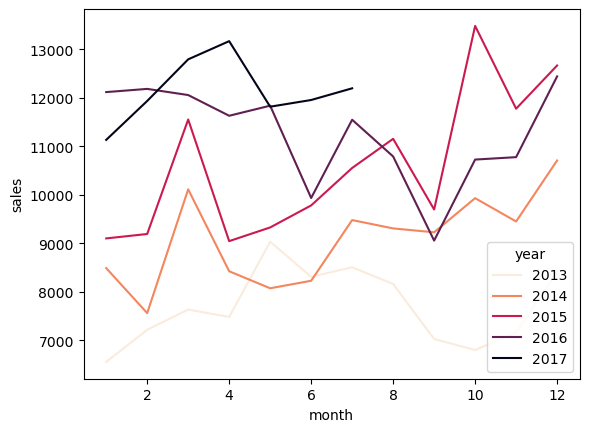

In [58]:
total_plot = sns.lineplot(x='month', y='sales', hue='year', palette='rocket_r', data=monthly_sales[monthly_sales["family"]=="AUTOMOTIVE"][:-1])